In [1]:
'''
Training a fully supervised one layer NMF on 20 news group dataset
'''
# define some global variables
save_PATH = 'saved_data/'
save_filename = 'supervised_one_layer'

In [2]:
# import package
%load_ext memory_profiler
import torch
from torch.autograd import Variable
import Ipynb_importer
from deep_nmf import Deep_NMF, Energy_Loss_Func, Fro_Norm
from writer import Writer
from matplotlib import pyplot as plt
import numpy as np
from auxillary_functions import *

In [3]:
# load the dataset for twenty news
from twenty_news_group_data_loading import data, Y, target,L20, L50, L90, sparsedata_cr_entr, sparsedata_L2#, get_whole_output

importing Jupyter notebook from twenty_news_group_data_loading.ipynb


In [75]:
# Define the network 
m = data.shape[1]
k = 20
c = 20
lambd = 1e-4
net = Deep_NMF([m, k], c)
loss_func = Energy_Loss_Func(lambd = lambd, classification_type = 'L2')
data_input = data*1000
dataset = sparsedata_L2(data_input, 1000*Y)
criterion = Fro_Norm()


In [71]:
# try initializing the network with the unsupervised version
#A = np.load(save_PATH + '20_news_group_A.npy')
#net.lsqnonneglst[0].A.data = torch.from_numpy(A)

In [76]:
net.linear.weight.data = torch.randn(net.linear.weight.data.shape).double()

In [ ]:
# Training process!
import time
# setting training parameters
batchsize = 1000
epoch = 40
lr = 1e6
lr_nmf = 5000
lr_cl = 5000
loss_lst = []
# train!
for epo in range(epoch):
    dataloader = torch.utils.data.DataLoader(dataset, batch_size = batchsize, shuffle = True)
    total_loss = 0
    for (i, (inputs, label)) in enumerate(dataloader):
        t1 = time.time()
        inputs = inputs.view([inputs.shape[0], inputs.shape[2]])
        label = label.view([label.shape[0], -1])
        inputs, label = Variable(inputs), Variable(label)
       #train the lsqnonneg layers
        net.zero_grad()
        S_lst,pred = net(inputs)
        loss = loss_func(inputs, S_lst,list(net.lsqnonneglst.parameters()),pred,label)
        loss.backward()
        loss_lst.append(loss.data)
        total_loss += loss.data
        print(loss.data)
        t2 = time.time()
        print(t2 - t1)
        for A in net.parameters():
            A.data = A.data.sub_(lr*A.grad.data)
        for A in net.lsqnonneglst.parameters():
            A.data = A.data.clamp(min = 0)
    print('epoch = ', epo, '\n', total_loss)

tensor(9.4478, dtype=torch.float64)
87.41873025894165
tensor(9.4467, dtype=torch.float64)
87.82430291175842
tensor(9.4681, dtype=torch.float64)
95.53686833381653
tensor(9.4258, dtype=torch.float64)
98.79695081710815
tensor(9.3624, dtype=torch.float64)
105.68007183074951
tensor(9.1866, dtype=torch.float64)
109.89492964744568
tensor(9.3280, dtype=torch.float64)
112.49032616615295
tensor(9.2759, dtype=torch.float64)
112.19051170349121
tensor(9.2203, dtype=torch.float64)
118.95234799385071
tensor(9.1752, dtype=torch.float64)
124.84013748168945
tensor(9.1761, dtype=torch.float64)
126.44540333747864
tensor(9.1860, dtype=torch.float64)
127.77572655677795
tensor(9.1340, dtype=torch.float64)
128.94819283485413
tensor(9.1387, dtype=torch.float64)
134.6072289943695
tensor(9.0279, dtype=torch.float64)
138.60238766670227
tensor(9.0262, dtype=torch.float64)
140.16196823120117
tensor(8.9047, dtype=torch.float64)
136.40167903900146
tensor(8.8505, dtype=torch.float64)
148.47789525985718
tensor(8.9729, 

In [41]:
# Training process!

# setting training parameters
batchsize = 100
epoch = 4
lr_nmf = 10000
lr_cl = 10000
loss_lst = []
# train!
for epo in range(epoch):
    dataloader = torch.utils.data.DataLoader(dataset, batch_size = batchsize, shuffle = True)
    total_loss = 0
    for (i, (inputs, label)) in enumerate(dataloader):
        inputs = inputs.view([inputs.shape[0], inputs.shape[2]])
        label = label.view([label.shape[0], -1])
        inputs, label = Variable(inputs), Variable(label)
        #%memit
        # train the linear classifier
        S_lst, pred = net(inputs)
        print('training the classifier')
        for A in net.lsqnonneglst.parameters():
            A.requires_grad = False
        for k in range(1):
            net.zero_grad()
            pred = net.linear(S_lst[-1].data)
            loss = criterion(pred, label)
            loss.backward()
            print(loss.data)
            for A in net.linear.parameters():
                A.data = A.data.sub_(lr_cl*A.grad.data)
#         %memit
        for A in net.lsqnonneglst.parameters():
            A.requires_grad = True
       #train the lsqnonneg layers
        net.zero_grad()
        S_lst,pred = net(inputs)
        loss = loss_func(inputs, S_lst,list(net.lsqnonneglst.parameters()),pred,label)
        loss.backward()
        loss_lst.append(loss.data)
        total_loss += loss.data
        print('training the nmf layer')
        print(loss.data)
        for A in net.lsqnonneglst.parameters():
            A.data = A.data.sub_(lr_nmf*A.grad.data)
            A.data = A.data.clamp(min = 0)
            A.requires_grad = False
    # should be deleted later on
    break
    print('epoch = ', epo, '\n', total_loss)

training the classifier
tensor(58375.2478, dtype=torch.float64)
training the nmf layer
tensor(13.2588, dtype=torch.float64)
training the classifier
tensor(1.00000e+05 *
       3.1508, dtype=torch.float64)
training the nmf layer
tensor(46978.0604, dtype=torch.float64)
training the classifier
tensor(1.00000e+05 *
       1.2350, dtype=torch.float64)
training the nmf layer
tensor(26.9418, dtype=torch.float64)


KeyboardInterrupt: 

In [19]:
# save the data
np.savez(save_PATH + save_filename,
         param_lst = list(net.parameters()), loss_lst = loss_lst)

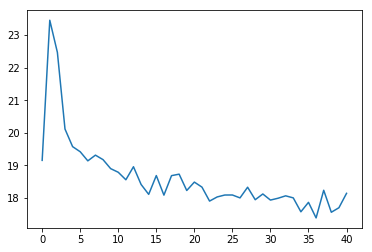

In [69]:
# plot the loss curve
plt.plot(loss_lst)
plt.show()
# # Get the whole output of the whole dataset (running forward propagation on the whole dataset)
# S, pred = get_whole_output(net, dataset)
# # Get the accuracy
# accuracy = torch.sum(torch.argmax(pred, 1) 
#                      == torch.argmax(torch.from_numpy(Y),1))/len(dataset)
# print(accuracy)
# # Get the reconstruction error
# A_np = net.lsqnonneglst[0].A.data.numpy()
# S_np = S.data.numpy()
# fro_error, fro_X = calc_reconstruction_error(data_input, A_np, S_np)
# print(fro_error/fro_X)

In [ ]:
# save the data
np.savez(save_PATH + save_filename, S = S, pred = pred,
         param_lst = list(net.parameters()), loss_lst = loss_lst)